<a name="page-top"></a>


# SURFACE DEFECT DETECTION

<a name="preambule"></a>
## 0) Preamble

<div style="text-align: justify">
For this use case, we choose to work with the <b><u>Severstal: Steel Defect Detection</u></b> dataset provided by the <a href = "https://www.severstal.com/eng/">PAO Severstal</a> mining company for a competition it launched on Kaggle at the end of 2019. They did so to optimize the quality system for their flat sheets of steel : <a href = "https://www.kaggle.com/c/severstal-steel-defect-detection">https://www.kaggle.com/c/severstal-steel-defect-detection</a>.


The dataset is comprised of images of surface defects of 4 different natures (ClassId=1..4). However not explicitely characterized, we can imagine that those 4 types of defect might for instance be 'Hole', 'Crack', 'Sliced Borders', and 'Corrosion'.
We will as far as we're concerned here, only bother discriminating between areas 'with defect' and areas 'with no defect'.<br />


The images are of dimension <em>256 x 1,600</em>.


To run this notebook on your machine, please download and unzip the dataset from Kaggle and store it in the "data" folder with your copy of the present Notebook as follows :
</div>

<img src="images/dataset.png" alt="Severstal dataset" width="150px" />

# Table of contents
1. <a href="#introduction">Introduction</a><br />
2. <a href="#visualizing">Visualizing defect masks</a><br />
3. <a href="#preprocessing">Data pre-processing</a><br />
4. <a href="#augmentation">Data augmentation</a><br />
5. <a href="#architecture">Model architecture</a><br />
6. <a href="#training">Model training</a><br />
7. <a href="#results">Results</a><br />

 <a href="#appendices">APPENDICES</a><br />
    1. <a href="#training_trace">Model training trace</a><br />
    2. <a href="#training_archi">Model detailed architecture</a>

<a name="introduction"></a>
<h2>1) Introduction <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>
<br />
<div style="text-align: justify">
For the purpose of highlighting surface defects on steel sheet images, we train a Semantic Segmentation model. The output of the model is a high-definition image of the same size as the input. In that output image, all the pixels are classified. In our case here, since we're only dealing with one class, which is "defect", we generate a pixel-by-pixel 0/1 mask for any defect identified in an input image.
</div>

In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import cv2
import numpy as np
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import Image, display

%matplotlib inline
plt.rcParams.update({'font.size': 12})

from mask_utils import rle_to_mask

%reload_ext autoreload
%autoreload 2


In [2]:
train_images_list = \
pd.DataFrame( {"ImageId": [entry.name for entry in os.scandir(os.path.join('data', 'train_images')) if entry.is_file()]} )
print( "{:,}".format( len( train_images_list ) ) + " training images" )

12,568 training images


<div style="text-align: justify">
To encode a "region with defect", the dataset uses <b>run-length encoding</b> on the pixel values, i.e. pairs of values that contain a start position and a run length. E.g. '1 3' implies starting at pixel 1 and running a total of 3 pixels (1,2,3). This encoding is stored in the "EncodedPixels" attribute of the metadata file.
</div>

In [3]:
train_csv = pd.read_csv(os.path.join('data', 'train.csv')).set_index(['ImageId'])
train_csv.head()

ClassId                                      EncodedPixels
ImageId                                                                  
0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
0007a71bf.jpg        3  18661 28 18863 82 19091 110 19347 110 19603 11...
000a4bcdd.jpg        1  37607 3 37858 8 38108 14 38359 20 38610 25 388...
000f6bf48.jpg        4  131973 1 132228 4 132483 6 132738 8 132993 11 ...
0014fce06.jpg        3  229501 11 229741 33 229981 55 230221 77 230468...

In [4]:
print("The metadata file accompgnying the " + "{:,}".format( len( train_images_list ) ) + " training images " +
      "contains some " + "{:,}".format( train_csv.shape[0] + 1 ) + " metadata rows.")

The metadata file accompgnying the 12,568 training images contains some 7,096 metadata rows.


Lets look into how these two collections match with each other :

In [5]:
train_data = pd.merge( pd.DataFrame( train_images_list ), train_csv, on='ImageId', how='outer')
train_data.head(10)

ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg      1.0  29102 12 29346 24 29602 24 29858 24 30114 24 3...
1  00031f466.jpg      NaN                                                NaN
2  000418bfc.jpg      NaN                                                NaN
3  000789191.jpg      NaN                                                NaN
4  0007a71bf.jpg      3.0  18661 28 18863 82 19091 110 19347 110 19603 11...
5  000a4bcdd.jpg      1.0  37607 3 37858 8 38108 14 38359 20 38610 25 388...
6  000f6bf48.jpg      4.0  131973 1 132228 4 132483 6 132738 8 132993 11 ...
7  0014fce06.jpg      3.0  229501 11 229741 33 229981 55 230221 77 230468...
8  001982b08.jpg      NaN                                                NaN
9  001d1b355.jpg      NaN                                                NaN

In [6]:
print( "{:,}".format( train_data.shape[0] ) + " total rows" )

12,997 total rows


Some images have no reported defect, some other have more than 1 'type' of defect (column 'ClassId').


* For the images with more than one 'ClassId' row, we will merge the masks further down this notebook.
<br />

<a name="visualizing"></a>
<h2>2) Visualizing defect masks <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style="text-align: justify">
Lets look into the 20 first images of steel sheets which have a reported area with surface defect. On the below training examples, we apply a blue mask on the defect(s) reported location(s) :
</div>

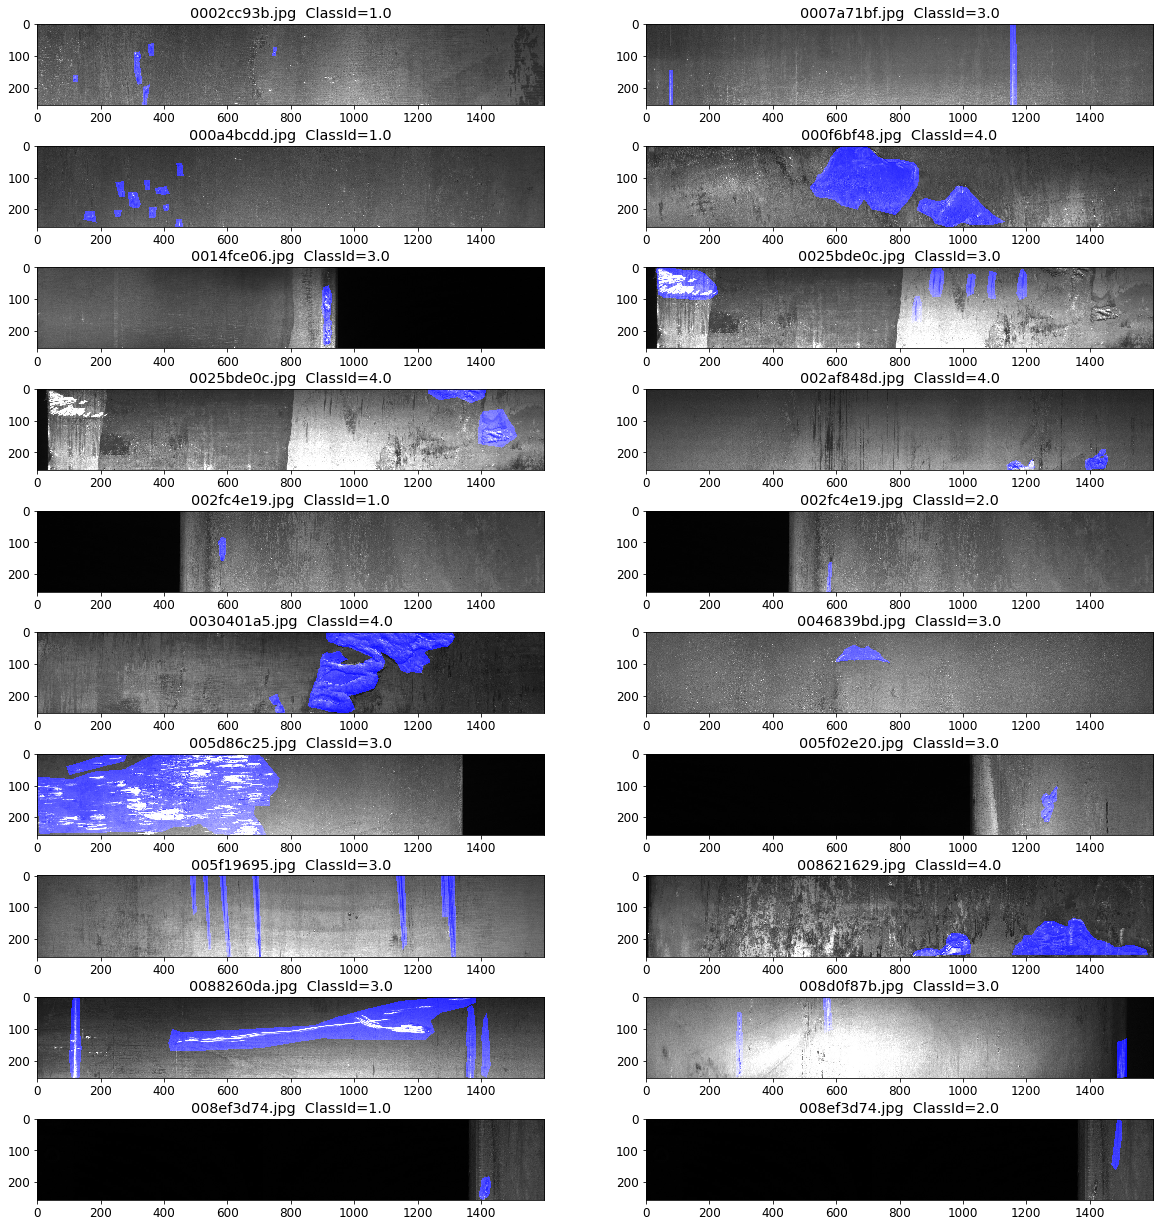

In [7]:
columns = 2
rows = 10
fig = plt.figure(figsize=(20,columns*rows+2))
filtered_train_data = train_data[train_data['EncodedPixels'].notnull()]
for i in range(0,columns*rows):
    fn = filtered_train_data['ImageId'].iloc[i]
    c = filtered_train_data['ClassId'].iloc[i]
    fig.add_subplot(rows, columns, i+1).set_title(fn+"  ClassId="+ str(c) )
    img = cv2.imread( os.path.join('data', 'train_images', fn ) )
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle_to_mask(filtered_train_data['EncodedPixels'].iloc[i], 256, 1600)
    # max value on the blue channel
    img[ mask==1, 2 ] = 255
    plt.imshow(img)
plt.show()

<div style="text-align: justify">
As we can see on the pictures above, the reported masks are rather rough around the actual defects. This will make the task of learning to recognize defects much harder for our model since many masked pixels are actually sain.
</div>

<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

<div style="text-align: justify">
We will now navigate the special case of steel sheet images with reported surface defects of 2 or more different types (i.e. steel sheets for which 2 or more 'ClassId' rows are listed in the training metadata provided with the training images).

Lets first group the RLEs per ImageId :
</div>

In [8]:
# get rid of 'ClassId' and, group RLEs into 1 list per 'ImageId'
grouped_train_data = train_data.groupby('ImageId')['EncodedPixels'].apply(list)
grouped_train_data.head()

ImageId
0002cc93b.jpg    [29102 12 29346 24 29602 24 29858 24 30114 24 ...
00031f466.jpg                                                [nan]
000418bfc.jpg                                                [nan]
000789191.jpg                                                [nan]
0007a71bf.jpg    [18661 28 18863 82 19091 110 19347 110 19603 1...
Name: EncodedPixels, dtype: object

We can now easily identify which image has more than 1 RLE (i.e. which image has reported defects of 2 or more different types) :

In [9]:
# identify and count the images with defects of more than 1 single class
# (in order to be able to later merge their masks into 1 per 'ImageId')
count2 = 0
count3 = 0
count4 = 0
for img in grouped_train_data.iteritems() :
    if len( img[1] ) == 2 :
        count2+=1
    elif len( img[1] ) == 3 :
        count3+=1
    elif len( img[1] ) == 4 :
        count4+=1
print( "{:,}".format( count2 ) + " images with defects of 2 different classes" )
print( "{:,}".format( count3 ) + " images with defects of 3 different classes" )
print( "{:,}".format( count4 ) + " images with defects of 4 different classes" )

425 images with defects of 2 different classes
2 images with defects of 3 different classes
0 images with defects of 4 different classes


As an illustration, lets look at an image with defects of 2 different classes and color-code those defect classes :

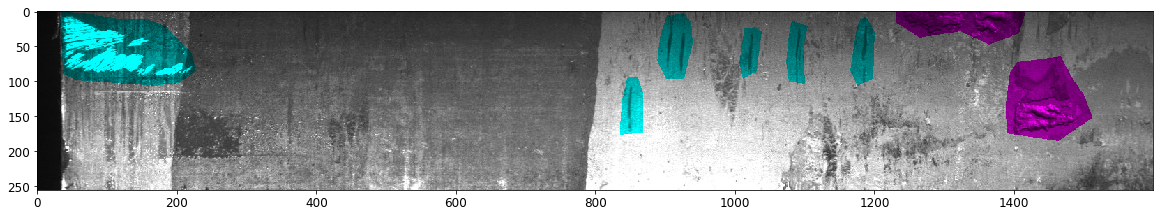

In [10]:
imageId = '0025bde0c.jpg'

len( grouped_train_data[imageId] )

img = cv2.imread( os.path.join('data', 'train_images', imageId) )

for color_channel, rle in enumerate( grouped_train_data['0025bde0c.jpg'] ) :
    mask = rle_to_mask( rle, 256, 1600 )
    img[ mask==1, color_channel ] = 1
fig = plt.figure(figsize=(20,4))
plt.imshow(img)
plt.show()

We will handle these cases in the upcoming section of the workbook.
<br /><br />

<a name="preprocessing"></a>
<h2>3) Data pre-processing <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style="text-align: justify">
We hereby prepare our training data so that it can be fed to our model for training. It simply consists in :
    - normalizing the input images (divinding the RGB color channels by 255)
    - computing the defects masks (from their respective RLE expression)
    - merge masks when there's more than 1 for a given training record
<br /><br />
Remark : We have seen earlier that many training images lack any defect RLE in the metadata provided by Serverstal. We sampled and looked into many of those cases and, some metadata rows are obviously missing. 
Since our goal is to train our model to identify and locate surface defects, we will only use images for which at least one defect have been reported.
</div>

In [11]:
path = os.path.join('data', 'train_images', 'preprocessed')
if not os.path.exists( path ) : os.mkdir( path )

In [12]:
start = timer()
count = 0
for img in grouped_train_data.iteritems() :
    # only consider training images with at least 1 reported defect
    if not pd.isnull(img[1])[0] :

        if not os.path.exists( os.path.join(path, img[0]) ) :
            # normalize the input image
            image = cv2.imread( os.path.join('data', 'train_images', img[0]) )
            norm_image = image # image.astype(np.float32) / 255. # moved standardization inside custom_data_generator
            cv2.imwrite( os.path.join(path, img[0]),  norm_image )

        name_suffix = img[0].partition( ".jpg" )[0]
        if (
            not os.path.exists( os.path.join(path, name_suffix + "_mask.jpg") )
        ) :
            # compute the defect mask
            if len( img[1] ) == 1 :
                # case of defects of a single class
                mask_image = rle_to_mask( img[1][0], 256, 1600)
            else :
                # case of defects of more than one class
                # (we merge the associated masks into 1)
                mask = np.zeros( (256, 1600) )
                for i, rle in enumerate( img[1] ) :
                    #print( img[0]+ " - " + str( len( img[1] ) ) + " - " + str( i ) + " : " + str( rle ) )
                    mask_i = rle_to_mask(rle, 256, 1600)
                    mask = mask + mask_i
                mask_image = ( mask > 0 ).astype('uint8')
            cv2.imwrite( os.path.join(path, name_suffix + "_mask.jpg"),  mask_image )

        count += 1

print( "{:,}".format( count ) + " training images with reported defect(s) available" )
print(timedelta(seconds=timer()-start))

6,666 training images with reported defect(s) available
0:00:01.193752


We can confirm below that, when applicable, we also applied the masks-merge operation and that it was succesful by looking at our previous example again. All the defects area is indeed covered by one single mask now :

data\train_images\preprocessed\0025bde0c_mask.jpg
1


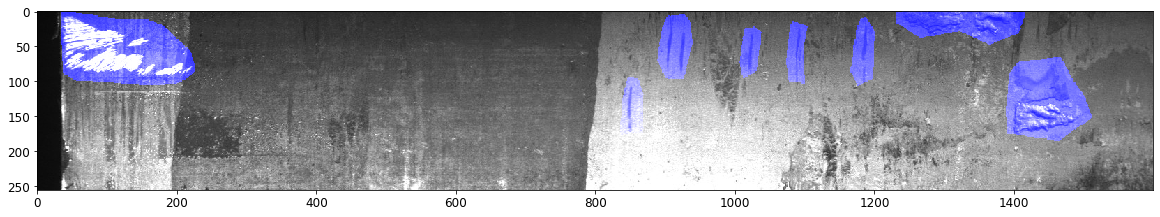

In [13]:
imageId = '0025bde0c.jpg'

img = cv2.imread( os.path.join('data', 'train_images', imageId) )

mask = cv2.threshold(
    cv2.imread( os.path.join(path, imageId.partition( ".jpg" )[0] + "_mask.jpg"), cv2.IMREAD_GRAYSCALE )
    , .5, 1, cv2.THRESH_BINARY)[1]
print( os.path.join(path, imageId.partition( ".jpg" )[0] + "_mask.jpg") )
print( np.amax(mask) )

# max value on the blue channel
img[ mask==1, 2 ] = 255

fig = plt.figure(figsize=(20,4))
plt.imshow(img)
plt.show()

<a name="augmentation"></a>
<h2>4) Data augmentation <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

For Deep Learning models to perform best, we can either increase the depth of their inner layers and/or use more data at training time. The purpose of data augmentation is to increase the amount of training data.

As can be observed on the below example, from one pair (image, defect mask), we will generate 3 additional new pairs. That way, our training sample will be quadrupled in size.

We will perform combinations of flipping and mirroring on each original training record. Let's look at what the result would be on one such training record (top-left quadran of the below picture) :

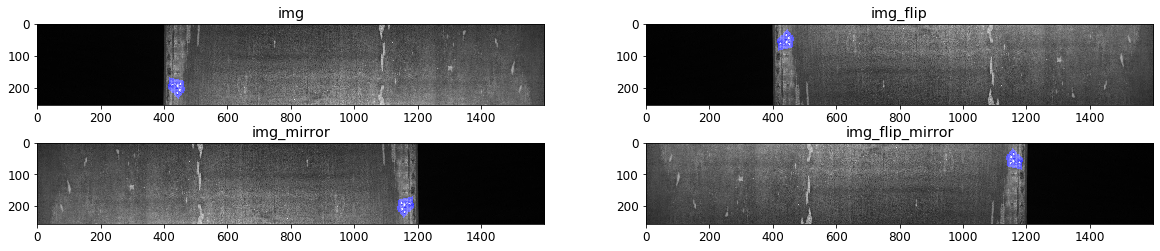

In [14]:
imageId = 'fffe98443.jpg' #'0002cc93b.jpg'
img = cv2.imread( os.path.join('data', 'train_images', imageId) )
mask = rle_to_mask(filtered_train_data[filtered_train_data.ImageId == imageId]['EncodedPixels'].iloc[0], 256, 1600)
img_flip_ud = cv2.flip(img, 0) # flip vertically
mask_flip_ud = cv2.flip(mask, 0)
img_flip_lr = cv2.flip(img, 1) # flip horizontally
mask_flip_lr = cv2.flip(mask, 1)
img_flip_ud_lr = cv2.flip(img, -1) # flip vertically and horizontally
mask_flip_ud_lr = cv2.flip(mask, -1)


fig = plt.figure(figsize=(20,4))
fig.add_subplot(2, 2, 1).set_title("img")
# max value on the blue channel
img[ mask==1, 2 ] = 255
plt.imshow(img)

fig.add_subplot(2, 2, 2).set_title("img_flip")
# max value on the blue channel
img_flip_ud[ mask_flip_ud==1, 2 ] = 255
plt.imshow(img_flip_ud)

fig.add_subplot(2, 2, 3).set_title("img_mirror")
# max value on the blue channel
img_flip_lr[ mask_flip_lr==1, 2 ] = 255
plt.imshow(img_flip_lr)

fig.add_subplot(2, 2, 4).set_title("img_flip_mirror")
# max value on the blue channel
img_flip_ud_lr[ mask_flip_ud_lr==1, 2 ] = 255
plt.imshow(img_flip_ud_lr)

plt.show()

Let us do that on the entire original training dataset then :

In [15]:
start = timer()
path = os.path.join('data', 'train_images', 'preprocessed')
count = 0
for img in grouped_train_data.iteritems() :
    # only consider training images with at least 1 reported defect
    if not pd.isnull(img[1])[0] :
        name_suffix = img[0].partition( ".jpg" )[0]
        image = None
        mask_image = None

        if not os.path.exists( os.path.join(path, name_suffix + "_flip.jpg") ) :
            if image is None :
                image = cv2.imread( os.path.join(path, img[0]) )
            image_flip = cv2.flip(image, 0) # flip vertically
            cv2.imwrite( os.path.join(path, name_suffix + "_flip.jpg"),  image_flip )

        if not os.path.exists( os.path.join(path, name_suffix + "_mask_flip.jpg") ) :
            if mask_image is None :
                mask_image = cv2.imread( os.path.join(path, name_suffix + "_mask.jpg"), cv2.IMREAD_GRAYSCALE )
            mask_image_flip = cv2.flip(mask_image, 0) # flip vertically
            cv2.imwrite( os.path.join(dest_path, name_suffix + "_mask_flip.jpg"),  mask_image_flip )

        if not os.path.exists( os.path.join(path, name_suffix + "_mirror.jpg") ) :
            if image is None :
                image = cv2.imread( path + img[0] )
            image_mirror = cv2.flip(image, 1) # flip horizontally
            cv2.imwrite( os.path.join(path, name_suffix + "_mirror.jpg"),  image_mirror )
        if not os.path.exists( os.path.join(path, name_suffix + "_mask_mirror.jpg") ) :
            if mask_image is None :
                mask_image = cv2.imread( os.path.join(path, name_suffix + "_mask.jpg"), cv2.IMREAD_GRAYSCALE )
            mask_image_mirror = cv2.flip(mask_image, 1) # flip horizontally
            cv2.imwrite( os.path.join(path, name_suffix + "_mask_mirror.jpg"),  mask_image_mirror )

        if not os.path.exists( os.path.join(path, name_suffix + "_flip_mirror.jpg") ) :
            if image is None :
                image = cv2.imread( path + img[0] )
            image_flip_mirror = cv2.flip(image, -1) # flip vertically and horizontally
            cv2.imwrite( os.path.join(path, name_suffix + "_flip_mirror.jpg"),  image_flip_mirror )
        if not os.path.exists( os.path.join(path, name_suffix + "_mask_flip_mirror.jpg") ) :
            if mask_image is None :
                mask_image = cv2.imread( os.path.join(path, name_suffix + "_mask.jpg"), cv2.IMREAD_GRAYSCALE )
            mask_image_flip_mirror = cv2.flip(mask_image, -1) # flip vertically and horizontally
            cv2.imwrite( os.path.join(path, name_suffix + "_mask_flip_mirror.jpg"),  mask_image_flip_mirror )

        count += 4


print( "{:,}".format( count ) + " training records available" )
print(timedelta(seconds=timer()-start))


26,664 training records available
0:00:02.670832


We then end-up with a brand new 4-times-larger training dataset :

In [16]:
input_images = [entry.name for entry in os.scandir( os.path.join('data', 'train_images', 'preprocessed') )
                if entry.is_file() and "_mask" not in entry.name]
#print( "{:,}".format( len(input_images) ) + " training images available" )

output_masks = [entry.name for entry in os.scandir( os.path.join('data', 'train_images', 'preprocessed') )
                if entry.is_file() and "_mask" in entry.name]
#print( "{:,}".format( len(output_masks) ) + " training masks available" )

df = pd.DataFrame( {"ImageId": input_images, "MaskId": output_masks} )
print( "{:,}".format( df.shape[0] ) + " training records available" )
df.head(10)

26,664 training records available


ImageId                          MaskId
0              0002cc93b.jpg              0002cc93b_mask.jpg
1         0002cc93b_flip.jpg         0002cc93b_mask_flip.jpg
2  0002cc93b_flip_mirror.jpg  0002cc93b_mask_flip_mirror.jpg
3       0002cc93b_mirror.jpg       0002cc93b_mask_mirror.jpg
4              0007a71bf.jpg              0007a71bf_mask.jpg
5         0007a71bf_flip.jpg         0007a71bf_mask_flip.jpg
6  0007a71bf_flip_mirror.jpg  0007a71bf_mask_flip_mirror.jpg
7       0007a71bf_mirror.jpg       0007a71bf_mask_mirror.jpg
8              000a4bcdd.jpg              000a4bcdd_mask.jpg
9         000a4bcdd_flip.jpg         000a4bcdd_mask_flip.jpg

<a name="architecture"></a>
<h2>5) Model architecture <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style="text-align: justify">
We will be training a U-Net model (<a href="https://arxiv.org/abs/1505.04597" target=_blank>arXiv:1505.04597</a>) which has shown very good semantic segmentation capabilities over the years, even on rather small datasets.

For ease of implementation and shortness of code, we will be building our model using <a href="https://github.com/qubvel/segmentation_models" target=blank>the "segmentation_models" package</a> which encompasses convenience methods and pre-trained backbones for several sementation model using Tensorflow and Keras.
</div>

<img src="images/u-net-architecture.png" alt="U-Net architecture" width="600px" />

<em>For more detailled views of the architecture of the model employed, please refer to the <a href="#training_archi">APPENDICES</a> at the bottom of this Notebook</em>.

In [17]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

import keras
from keras import backend as K
from keras.layers import Input, Conv2D
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import Model

from segmentation_models import Unet

from model_utils import dice_coef, custom_data_generator

import dill as pickle

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


We'll use the <a href="https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient" target="_blank">Dice similarity coefficient</a> as our performance metric (@see [model_utils.dice_coef](./model_utils.py)).

<div style="text-align: justify">
To save GPU memory and thus <b>allow for larger training batches</b>, we'll downgrade the input images from 3 channels to 1 channel. Since they are gray scale images, no information is lost and this does not impact performance negatively. We'll also resize them to half their original width and height.


By doing so, an input image goes from 256 x 1,600 x 3 = <u>1,228,800</u> down to 128 x 800 = <u>102,400</u> pixels each.
</div>

In [18]:
base_model = Unet(
    backbone_name='resnet34',
    input_shape=(128, 800, 3),
    encoder_weights='imagenet',
    classes=1,
    activation='sigmoid'
)
inp = Input(shape=(128, 800, 1)) # gray-scaled input
l1 = Conv2D(3, (1, 1))(inp) # map 1 channel to 3 channels (from original U-Net)
out = base_model(l1)

model = Model(inp, out, name=base_model.name)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

<div style="text-align: justify">
Note that we here chose to stick to a classical 'binary_crossentropy' loss function when we could have used a more sophisticated one like for instance <a href="./model_utils.py" target=_blank>model_utils.bce_dice_loss</a>. Experiments have shown that better results were achieved on steel sheet images with the former.



</div>

<a name="training"></a>
<h2>6) Model training <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style="text-align: justify">
We use a batch size of 32 training records and feed our model during training using a <a href="./model_utils.py" target=_blank>model_utils.custom_data_generator</a> to generate data on the fly (so as to not require unpractical amounts of physical memory).


We split our training data into 80% for actual training and the remaining 20% for validation.
</div>

In [19]:
BATCH_SIZE = 32

idx = int(0.80*df.shape[0])
print( "{:,}".format( idx ) + ' training records ; + ' + "{:,}".format( df.shape[0] - idx ) + ' validation records.')
train_batches = custom_data_generator(df.iloc[:idx],batch_size=BATCH_SIZE,shuffle=True)
valid_batches = custom_data_generator(df.iloc[idx:],batch_size=BATCH_SIZE)

21,331 training records ; + 5,333 validation records.


<div style="text-align: justify">
We ran our training on the cloud using a Tesla P100 GPU (3584 CUDA cores, 16GB{16.28GB Usable} GDDR6 VRAM, <a href="https://images.nvidia.com/content/tesla/pdf/nvidia-tesla-p100-PCIe-datasheet.pdf" target=_blank>@see spec sheet</a>) and an additionnal 15.26 GB of RAM for CPU.
    

On that environment, training our model takes a little over 5 hours.
</div>

```python
PATIENCE = 10
path = os.path.join('model') ; if not os.path.exists( path ) : os.mkdir( path )

start = timer()

history = model.fit_generator(
    train_batches,
    validation_data = valid_batches,
    epochs = 40,
    callbacks = get_callback(PATIENCE),
    verbose = 1 )

model.save(os.path.join('model', 'my_model.h5')

with open('train_hstory.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(timedelta(seconds=timer()-start))
```

The full trace can be found as an [APPENDIX](#appendices) at the bottom of this Notebook.

<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

<div style="text-align: justify">
Once trained and saved as per the above command, we can reload our model (not provided here, please read further down this section for <a href="#lighter_format">a lighter format</a>) and display some basic training plots :
</div>

In [20]:
import tensorflow as tf
print( '- Tensorflow ' + tf.__version__ )
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

model = tf.keras.models.load_model(
    os.path.join('model', 'my_model.h5'),
    custom_objects = {'dice_coef': dice_coef}
)
print( '- trained model loaded from h5df local file' )
with open(os.path.join('model', 'train_hstory.pickle'), 'rb') as f:
    history_reloaded = pickle.load(f)
history_df = pd.DataFrame(history_reloaded)
print( '- model training history loaded from pickle local file' )

- Tensorflow 1.13.1
- trained model loaded from h5df local file
- model training history loaded from pickle local file


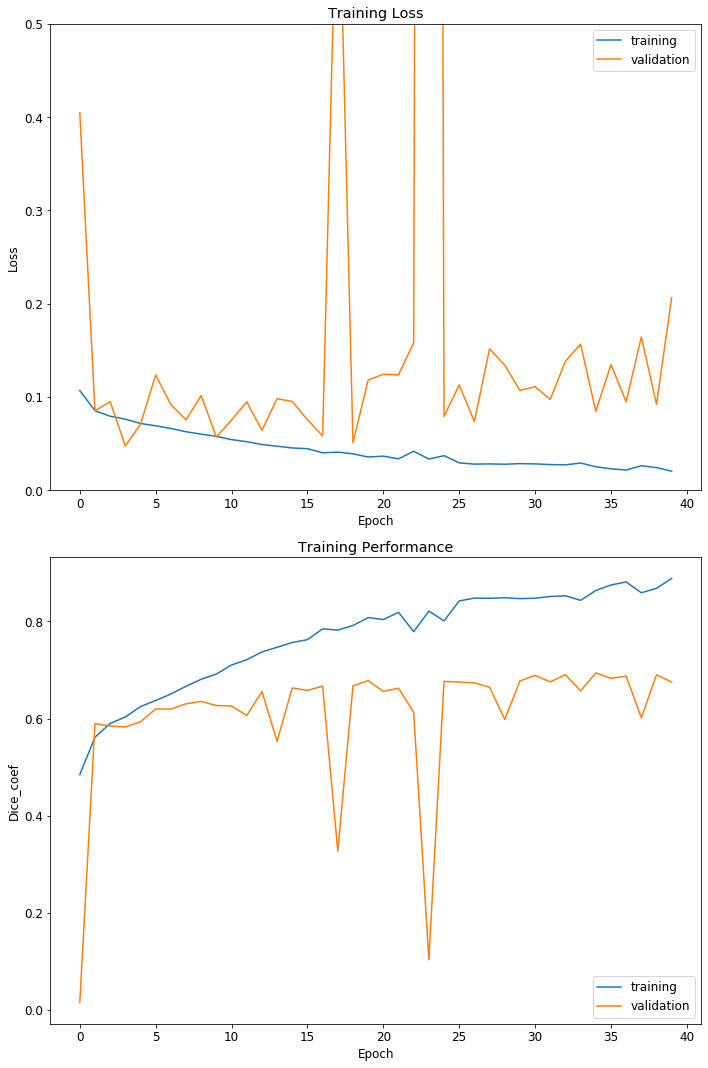

In [21]:
# PLOT TRAINING
fig = plt.figure(figsize=(10,15))

fig.add_subplot(2, 1, 1).set_title('Training Loss')
plt.plot(history_df.index,history_df['loss'],label='training')
plt.plot(history_df.index,history_df['val_loss'],label='validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(loc="upper right"); plt.ylim(0, .5)

fig.add_subplot(2, 1, 2).set_title('Training Performance')
plt.plot(history_df.index,history_df['dice_coef'],label='training')
plt.plot(history_df.index,history_df['val_dice_coef'],label='validation')
plt.xlabel('Epoch'); plt.ylabel('Dice_coef'); plt.legend(loc="lower right");

fig.tight_layout()
plt.show()

We can observe that progress on the validation dataset is rather slow and that it quickly plateaus.

<a name="lighter_format"></a>
<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />


<div style="text-align: justify">
    To save our model into a <b><u>lighter format</u></b>, we save it as a 2-components object : "architecture" + "weights". This version encompasses neither :<br />
<hr style="height:0pt; visibility:hidden; margin-bottom: 5px; margin-top:0px;" />
<ul style="margin: 0 5px 0 50px; /* top right bottom left*/">
    <li>the training configuration (loss, optimizer)</li>
    <li>the state of the optimizer, which is intended to allow to resume training where it was left off</li>
</ul>
<hr style="height:0pt; visibility:hidden; margin-bottom: 5px; margin-top:0px;" />
This operation divides the size of the local model by a factor of 3.
</div>

In [22]:
import json

# save archi as JSON
json_string = model.to_json()
with open(os.path.join('model', 'my_model_archi.json'), 'w', encoding='utf-8') as f:
    str_ = json_string
    f.write(str(str_))

# save weights as h5df
model.save_weights(os.path.join('model', 'my_model_weights.h5'))

This model can then be reloaded using the following few lines :

```python
# model reconstruction from JSON :
from tensorflow.keras.models import model_from_json

with open(os.path.join('model', 'my_model_archi.json'), 'r') as f:
    json_string = f.read()

model_reconstructed = model_from_json(json_string)

# model trained weights loading from h5df :
model_reconstructed.load_weights(os.path.join('model', 'my_model_weights.h5'))
```

This is the approach we use in the Docker solution which integrates our model thru an API layer. This light version of the trained model is available here. Look for it with the <span style="background-color: #e0e0e0">&nbsp;defect-api-service&nbsp;</span> source code.

<a name="results"></a>
<h2>7) Results <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<div style="text-align: justify">
Now that we have a model that makes predictions on probabilities for pixels in an input image to be of a defect, we can elaborate further on how to display those probabilities.


Lets take the same example as earlier in this Notebook. The below chart showcases several possible options to display the result of our predictions. We can compare these options with the first figure, which represents the ground truth that we have already seen :
</div>

prediction made in 0.086 seconds
highest predicted pixel defect probability : 99.99%


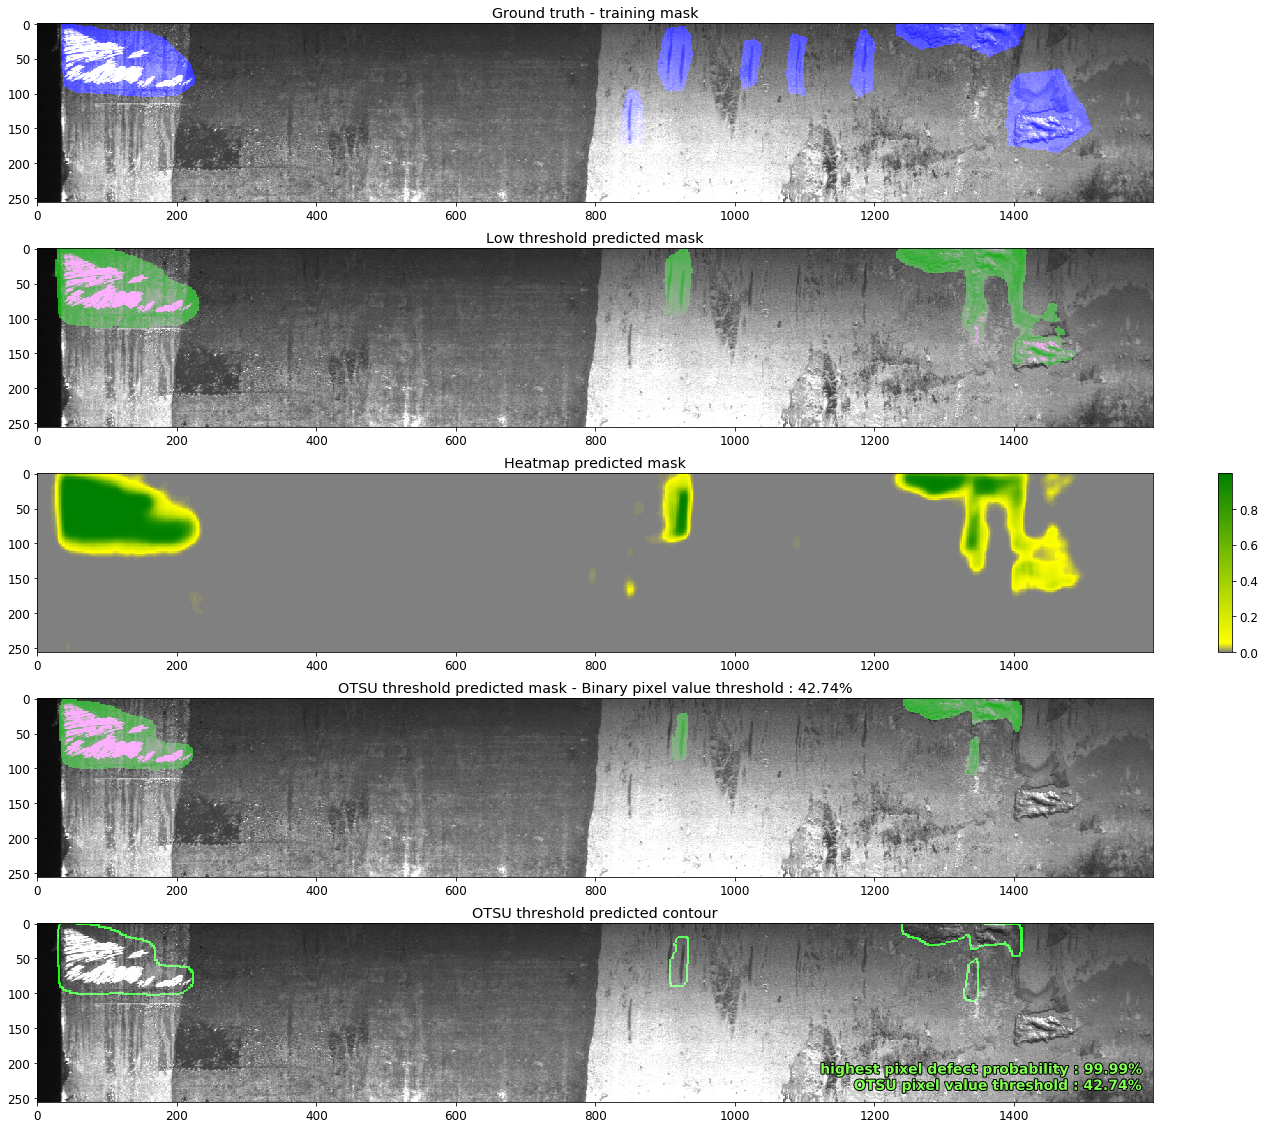

In [23]:
from model_utils import get_predicted_defects_mask
from mask_utils import mask_add_pad, mask_to_contour

imageId = '0025bde0c.jpg'

## input image ##
img = cv2.imread( os.path.join('data', 'train_images', imageId) )
if img is None :
    img = cv2.imread( os.path.join('data', 'test_images', imageId) )

## training_mask ##
training_mask = cv2.imread(os.path.join('data', 'train_images', 'preprocessed', imageId.partition(".jpg")[0] + "_mask.jpg")
                           , cv2.IMREAD_GRAYSCALE)

## predicted defects ##
predicted_mask = get_predicted_defects_mask( model, img, verbose = 1 )
max_pixel_prob = np.amax(predicted_mask)
print( "highest predicted pixel defect probability : " + '{0:2.2%}'.format( max_pixel_prob // 0.0001 / 10000 ) )

## plots ##
fig = plt.figure(figsize=(20,20))

fig.add_subplot(5, 1, 1).set_title('Ground truth - training mask')
training_img = img.copy()
if not training_mask is None :
    training_mask = cv2.threshold( training_mask, .5*max_pixel_prob, 1, cv2.THRESH_BINARY)[1]
    training_img[ training_mask==1, 2 ] = 255 # max value on the blue channel
plt.imshow(training_img)

fig.add_subplot(5, 1, 2).set_title('Low threshold predicted mask')
predicted_mask_lowthreshold = cv2.threshold( predicted_mask, .05, 1, cv2.THRESH_BINARY)[1]
lowthreshold_img = img.copy() ; lowthreshold_img[ predicted_mask_lowthreshold==1, 1 ] = 175 # max value on the green channel
plt.imshow(lowthreshold_img)

ax = fig.add_subplot(5, 1, 3)
ax.set_title('Heatmap predicted mask')
color_map = mpl.colors.LinearSegmentedColormap.from_list(
    'unevently divided', [(0, 'gray'), (.05, 'yellow'), (1, 'green')])
im = plt.imshow(predicted_mask, cmap = color_map)
box = ax.get_position()
axColor = plt.axes([box.x0*1.05 + box.width * 1.05, box.y0, 0.01, box.height])
plt.colorbar(im, cax = axColor, orientation="vertical")

fig.add_subplot(5, 1, 4)
predicted_mask_otsu = (predicted_mask*255).astype('uint8')
(thresh, predicted_mask_otsu) = cv2.threshold(
    predicted_mask_otsu, np.amax(predicted_mask_otsu)/2.,
    np.amax(predicted_mask_otsu),
    cv2.THRESH_BINARY | cv2.THRESH_OTSU
)
otsu_img = img.copy()
otsu_img[ predicted_mask_otsu==np.amax(predicted_mask_otsu), 1 ] = 175 # max value on the green channel
plt.imshow(otsu_img)
#plt.title('OTSU threshold predicted mask - B&W pixel value threshold : ' + "{:10.3f}".format( thresh/255 ) )
plt.title('OTSU threshold predicted mask - Binary pixel value threshold : ' + '{0:2.2%}'.format( thresh/255//0.0001/10000 ) )


ax = fig.add_subplot(5, 1, 5)
ax.set_title('OTSU threshold predicted contour')
#predicted_contour_otsu = cv2.threshold( predicted_mask, thresh, np.amax(predicted_mask_otsu), cv2.THRESH_BINARY)[1]
predicted_contour_otsu = mask_to_contour( mask_add_pad( predicted_mask_otsu, pad = 3 ) , width = 3 )
lowthreshold_contour_img = img.copy()
lowthreshold_contour_img[ predicted_contour_otsu==1, 1 ] = 255 # max value on the green channel
plt.imshow(lowthreshold_contour_img)
txt = ax.text(
    .99, .05,
    "highest pixel defect probability : " + '{0:2.2%}'.format( max_pixel_prob // 0.0001 / 10000 ) + "\n" +
    'OTSU pixel value threshold : ' + '{0:2.2%}'.format( thresh/255//0.0001/10000 ),
    horizontalalignment='right',
    verticalalignment='bottom',
    fontsize=14, color='#82ff51', weight='bold',
    transform=ax.transAxes)
# add text contour, in case it is above a deffect (same color)
txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])

plt.show()

<div style="text-align: justify">
On the above chart, the top figure is just a repetition of a figure we've already seen earlier, which is the blue-highlighting of the defect area as reported by Severstal in the training dataset. On the other hand, the other 4 figures are different ways to present the result of our prediction from the raw image :
<br />
<hr style="height:0pt; visibility:hidden; margin-bottom: 5px; margin-top:0px;" />
<ul style="margin: 0 5px 0 50px; /* top right bottom left*/">
    <li>The first one highlights in green any pixel that is deemed defectuous by more than 5% probability</li>
        <li>the second one is a heatmap of all pixel probabilities to be defectuous, with a color-coding depicted on the right color bar with probabilities starting at 0% in gray.</li>
        <li>the third one highlights in green any pixel that is deemed defectuous by more than a certain probability. The value of that "threshold" probability (above which a pixel is deemed defectuous) is determined using <a href="https://en.wikipedia.org/wiki/Otsu%27s_method" target=_blank>OTSU's method for image binarization</a>.</li>
        <li>the last figure is the same as the previous one except that, here, instead of highlighting any defectuous pixel in green, we put a contour green line around a defectuous area.</li>
    </ul>
</div>

<div style="text-align: justify">
In short, we've developped a model making a prediction from a flat steel sheet input image. As a last addition to our defect detection system, we made it possible to report our prediction as a JSON serialized object which we'll use as an API outbound in our Docker solution :
</div>

In [24]:
from mask_utils import prediction_to_json

json_prediction = prediction_to_json( predicted_mask )

json_obj = json.loads(json_prediction)

print( "{:,}".format( len(json_obj['contour_pixels']) ) + " contour pixels" )

json_obj['contour_pixels'] = json_obj['contour_pixels'][0:3] + ['...']
print( json.dumps( json_obj, indent = 4 ) ) # prettify (human-readable)

1,316 contour pixels
{
    "max_prob": 0.9999987483024597,
    "defect_thresh": 0.42745098039215684,
    "contour_pixels": [
        [
            0,
            35
        ],
        [
            0,
            36
        ],
        [
            0,
            37
        ],
        "..."
    ]
}


<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />

<a name="appendices"></a>
<h2>APPENDICES <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h2>

<a name="training_trace"></a>
<h3>Model training trace : <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

<img src="images\training_trace.png" alt="training trace" width="100%">

<a name="training_archi"></a>
<h3>Model detailed architecture : <small><em><a href="#page-top">(go back to top &uarr;)]</a></em></small></h3>

In order to downgrade the input from 3 (color) to 1 channel (gray scale), we did prepend a convolutional layer to the standard U-Net model :

In [25]:
model.summary()
print()
print(model.layers[2].name + " =>")
model.layers[2].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 800, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 800, 3)       6         
_________________________________________________________________
model_2 (Model)              (None, 128, 800, 1)       24456154  
Total params: 24,456,160
Trainable params: 24,438,810
Non-trainable params: 17,350
_________________________________________________________________

model_2 =>
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
________________________________________________________________________________

[(go back to top ↑)](#page-top)
<br />
<br />
<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />
<br />

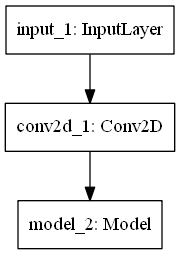

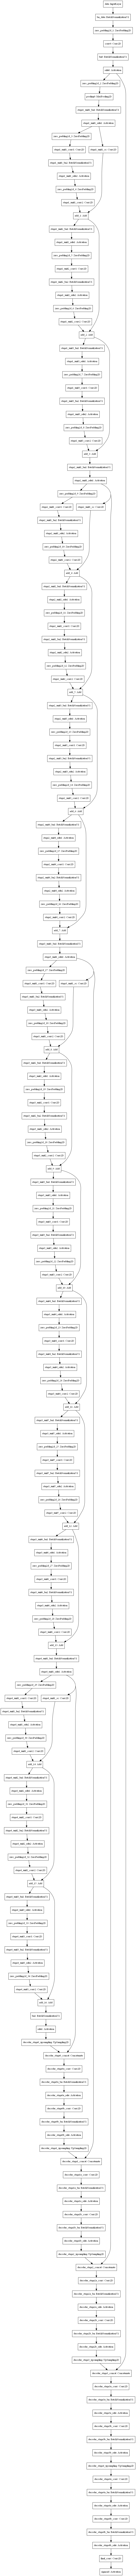

In [26]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file=os.path.join('model', 'my_model.png'))
plot_model(model.layers[2], to_file=os.path.join('model', model.layers[2].name + '.png'))
display(Image(filename=os.path.join('model', 'my_model.png')))
display(Image(filename=os.path.join('model', model.layers[2].name + '.png')))

[(go back to top ↑)](#page-top)
<br />
<br />
<hr style="height:2px;border-width:0;color:gray;background-color:gray;width:80%" />
<br />